> GitHub links:
> [final individual repo](https://github.com/jennifermei/voter_prediction), [group repo](https://github.com/am123320/PIC16B_Politics)

You can replicate my results by downloading the individual repo, ensuring you have all the necessary requirements (found in `requirements.txt`), and running `main.py`. It has taken me about five minutes to run on average and may take longer depending on your computer; when all the data has been processed, a tab will automatically open on your browser and you will be able to use the website. Visit the individual repo's `README.md` file for more information.

## Overview

This project uses election data and community demographic data from 2014, 2016, and 2018 to predict how different congressional districts will vote in 2020. Determining the factors that contribute to how US citizens vote in elections is important for political scientists and political campaigns. This project uses machine learning to use the relationship between a congressional district's demographic profile and how that district votes in U.S. House of Representatives elections. It focuses on racial makeup, education levels, and income, as well as some other factors.

I used the U.S. Census Bureau's API for the American Community Survey to gather the community demographic data, and I scraped Wikipedia for elections results and vote counts. Using these, I created and trained Random Forest models on 2014, 2016, and 2018 data and used those models to predict the percentage of Democratic and Republican votes for each congressional district in 2020. Finally, I created a website to allow users to view the predictions, choosing either an existing congressional district, making their own with different demographic profiles, or just viewing the entire United States!

The technical components I used are: web scraping, using an API call to handle messy data, complex data visualization using plotly, building a GUI, and building a dynamic website. I will expand upon these later.

Here is a general flowchart of the process:

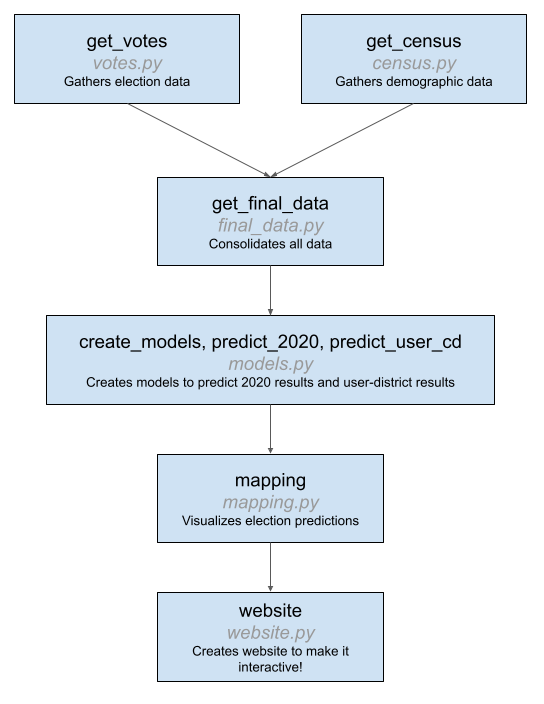

In [4]:
display.Image("flowchart.png")

## Web Scraping

I used web scraping to gather congressional election data from Wikipedia across all 50 states for the years 2014, 2016, 2018, and 2020. I used `requests` for making HTTP requests and `BeautifulSoup` for parsing HTMl content. I wanted to create a dataframe containing the number of votes received by Democratic and Republican candidates in the general congressional election for each district for every year, as well as the total number of votes cast.

For each year and state, I constructed the correct Wikipedia URL for data retrieval, sent an HTTP request to that URL, parsed the HTML content using `BeautifulSoup`, and searched for tables containing the desired election data. This gave me the data for each congressional district within the state, distinguishing between single-district states and multi-district states. The scraped data was stored in a `pandas DataFrame` and saved as a `CSV` file.

My main difficulties were that (A) not every Wikipedia article had the same data formatting, and (B) single-district states and multi-district states had different formatting, and (C) multi-district states had tables for every Congressional election in the state, not just an overall table with all the data.

In [ ]:
##### web scraping code snippet #####

for year in years:
    for state in state_names:
        # get wikipedia url for election data
        url = get_url(state, year)

        # http request to url to get html content and scrape
        response = requests.get(url)
        html_content = response.text
        soup = BeautifulSoup(html_content, 'html.parser')

        # find table with congressional election data
        table = soup.find('table', {'class': 'wikitable plainrowheaders sortable'})

        if table:
            # iterate through rows to extract data
            for row in table.find_all('tr')[1:]:
                columns = row.find_all('td')
                if columns:
                    # find district name
                    district_name = columns[0].text
                    district_name = district_name[len("District "):]
                    # find party name
                    top_row = table.find_all('tr')[0].text
                    party = top_row.split()[1]
                    # get votes based on party affiliation
                    if party == "Republican":
                      # ...
                    if party == "Democratic":
                      # ...
                    # get total votes in that election ...


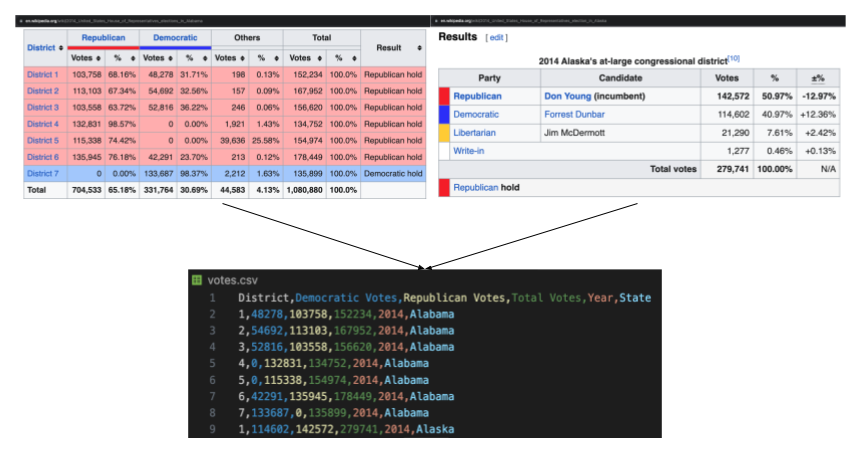

In [6]:
display.Image("webscraping.png")

## Using an API Call to Handle Messy Data

I used API calls from the `censusdata` library to handle and consolidate messy data from the U.S. Census Bureau. I wanted to retrieve census data across all 50 states from the [American Community Survey](https://www.census.gov/data/developers/data-sets/acs-5year.2014.html#list-tab-1036221584), then create a dataframe with all the demographic information of each congressional district.

I got an API key from the U.S. Census Bureau, went through each year and state, and made API calls using the `censusdata.download()` function. This function fetches data for specific geographical regions and specific ACS variables; for my purposes, this was congressional districts and the dictionary of ACS variables I thought may be useful. The data is then all stored into a `pandas DataFrame` and saved as a `CSV` file.

My main difficulty was parsing through the list of ACS codes and determining which variables would be useful for my purposes.

In [ ]:
##### api call code snippet #####

for year in years:
    for state in state_fips:
        data = censusdata.download(
            "acs5",
            year,
            censusdata.censusgeo([("state", state), ("congressional district", "*")]),
            acs_codes,
            key = api_key
        )

        data["Year"] = year
        data["State FIPS"] = state
        data["State Abbr"] = state_abbrs[state_fips.index(state)]

        # add congressional district number column
        number = data.index.astype(str).str.split().str[2]
        if number[0] == "(at":
            data["District"] = 1
        else:
            data["District"] = number

        # combine all data
        all_data = pd.concat([all_data, data])

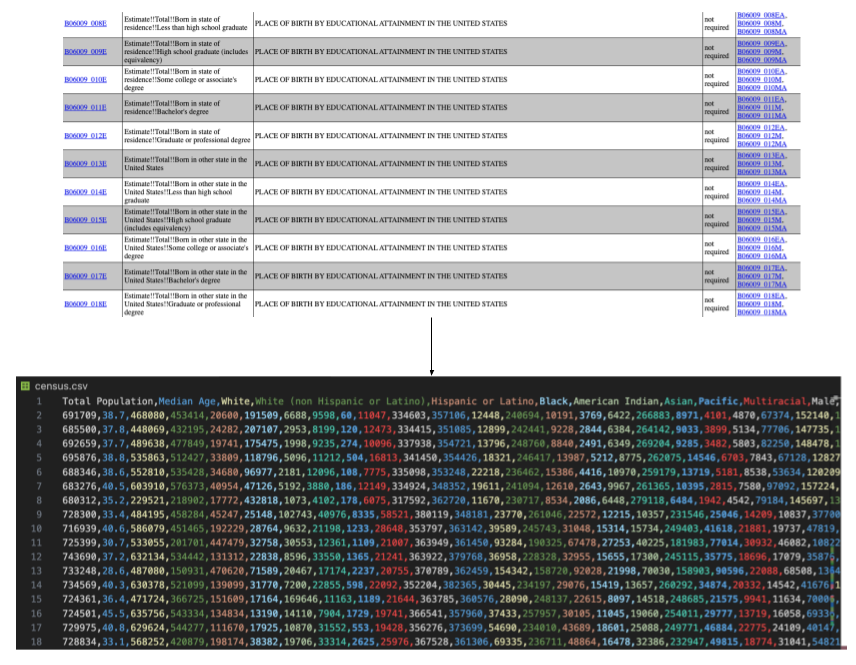

In [7]:
display.Image("api.png")

## Complex Data Visualization Using Plotly
I used `Plotly Express` to create complex data visualizations and generate interactive chloropleth maps based on election predictions and geographic data. I combined the prediction data with `GeoJSON` geographic data to visualize what party each district leaned toward across the United States.

I preprocessed the election prediction data, [found a GeoJSON file](https://eric.clst.org/tech/usgeojson/) with the geographic data that worked well for my project, and prepared it for mapping by distinguishing between two situations. The first is if the user wants to view a specific congressional district and the second is if the user just wants to view the country as a whole. I include the state, district, actual winner, and all my predictions as hover data in the map.

My main difficulty was differentiating between the two situations, and determining what code could be recycled and what needed to be specific for each situation.

In [ ]:
##### plotly code snippet #####

if state is None and district is None:
    # ... country-view specs ...
else:
    # ... congressional district specs ...
    # find center coordinates for selected state and district
    for feature in geo_data["features"]:
        if feature["properties"]["STATE"] == state and feature["properties"]["CD"] == district:
            coords = feature["geometry"]["coordinates"][0]
            center_lat, center_lon = calculate_center(coords)
            found = True
            break
    if not found:
        return "no json"

# create map
fig = px.choropleth_mapbox(predictions, geojson=geo_data, locations='FIPS_CD', color='Dem Advantage',
                            color_continuous_scale="RdBu",
                            range_color=(-50, 50),
                            mapbox_style="carto-positron",
                            color_continuous_midpoint=0,
                            zoom=zoom_level,
                            center={"lat": center_lat, "lon": center_lon},
                            opacity=0.7,
                            labels={'Dem Advantage': 'Predicted Dem Advantage %'},
                            hover_data=['State', 'District', 'Winner', 'Predicted Winner', 'Predicted Democratic %', 'Predicted Republican %'],
                          )
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

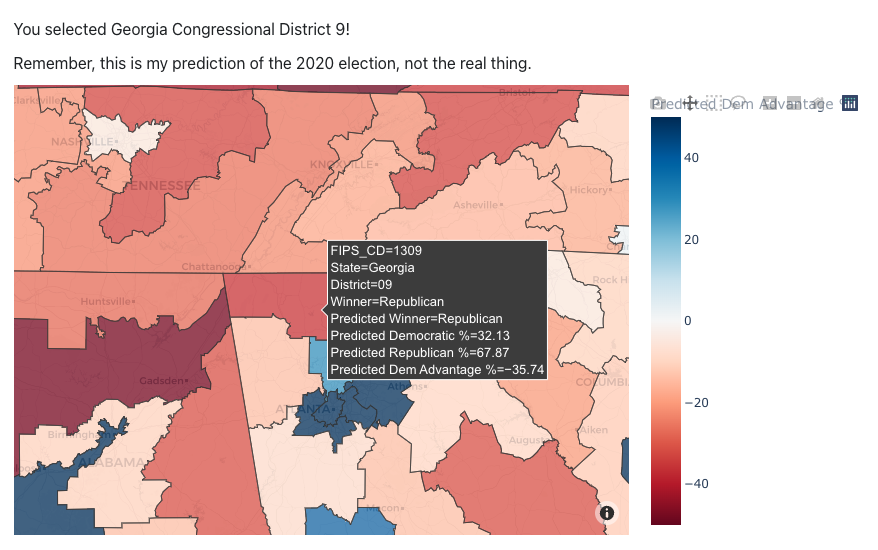

In [8]:
display.Image("district.png")

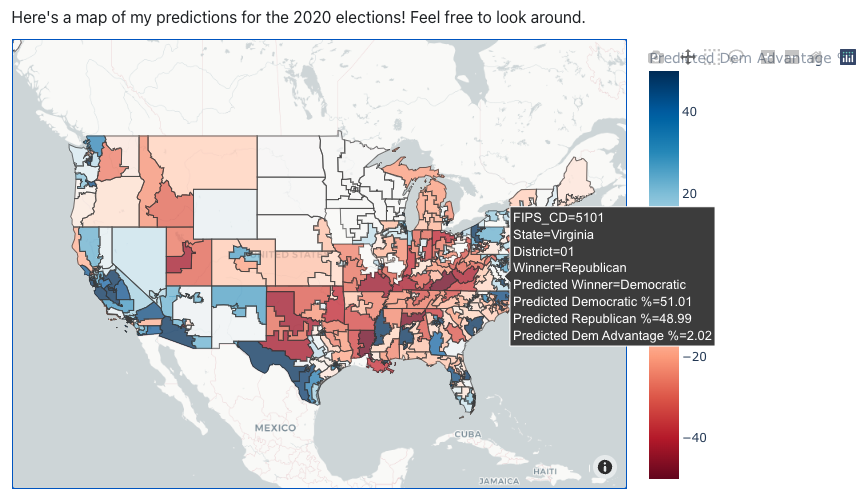

In [9]:
display.Image("country.png")

## Building a GUI
I built a Graphical User Interace (GUI) using the `PySimpleGUI` library to collect user-input demographic data. I wanted to create an interactive interface that allows users to input their desired demographic profile, such as playing with different racial makeups or education levels of a congressional district, to see how that affects election predictions.

The interface includes sections for racial makeup, education level, income, and other demographic factors. Each section has input fields for specifying percentages for those factors. I created a check to make sure that the total percentages in each category do not exceed 100% (it would not make sense to have all the racial makeups sum up to 130% of the population). I also prefilled each input box with the nationwide median for each demographic factor. A user's valid input is stored in a dictionary for later use.

My main difficulty was getting the medians to appear as prefilled options.

In [ ]:
##### gui code snippet #####

layout = [
    [sg.Text("Input desired demographics.", font=20)],
    [sg.Text("(Prefilled with nationwide medians.)", font=10)],
    [sg.Text("Racial Makeup", font=18)],
    input_row("White (non Hispanic or Latino) %", "White_non_Hispanic", medians['White (non Hispanic or Latino) %']),
    # ...
    [sg.Text("Education Level", font=18)],
    # ...
    [sg.Text("Income:", font=18)],
    # ...
    [sg.Text("Other:", font=18)],
    # ...
    [sg.Button("Submit")]
]

window = sg.Window("Demographic Profile", layout)

while True:
    event, values = window.read()
    if event == sg.WINDOW_CLOSED:
        break
    if event == 'Submit':
        categories = [racial, education, income]
        # check if input data is valid
        invalid_categories = [category for category in categories if not valid_100(category, values)]
        voter_turnout = float(values['-IN-Voter_Turnout'])
        # ...
        # makes sure categories don't exceed 100%
        if invalid_categories or voter_turnout > 100 or below_poverty_line > 100:
            # ...
            sg.popup_error(error_message)
        else:
            # store user input in dictionary
            sg.popup("Percentages are valid.")
            # ...
            break

window.close()

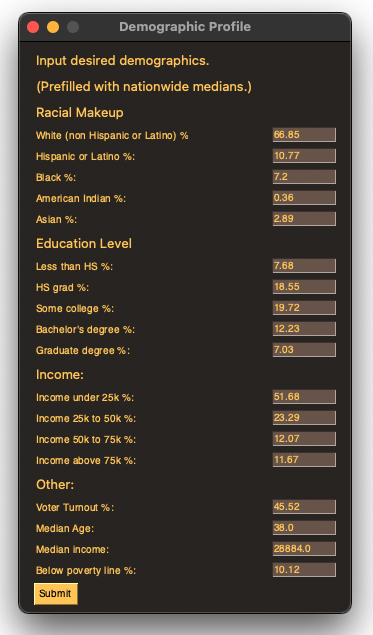

In [10]:
display.Image("gui.png")

## Building a Dynamic Website
I built a dynamic web application using the `PyWebIO` library. I wanted to create an interactive website for election prediction and mapping, offering three options. Users can select an existing congressional district and view my predictions for how that district would vote in the 2020 election, and which party would win compared against the actual winner. Users can also create their own custom district with a specific demographic profile and get a prediction on how that district would vote. Lastly, users could view the entire map with predictions for 2020 elections.

When a user selects a state and congressional district, the website predicts the election outcome for that district in 2020 and displays the result on an interactive map that is zoomed into that congressional district. The hover data includes predicted Democratic % and Republican %, as well as the predicted and actual winner. If the user chooses to create their own district, a GUI collects their demographic data and then predicts the election outcome based on that data, displaying those predictions along with the demographic profile. Lastly, for viewing the full country, the website displays a map of the United States displaying predictions for all congressional districts in 2020.

My main difficulty with building this website was pretty much everything. There was almost nothing that I didn't run into an issue with, but the most notable issues included getting the maps to show up with `PyWebIO`, getting the GUI to work with the `PyWebIO`, and just having the different actions given the selected option.

In [ ]:
##### website code snippet #####

while True:
    clear()
    # choose an option for what to view
    choice = radio("Choose a congressional district, make your own, or just look at the whole map!", options=['Select a state and district', 'Make my own district', 'Just show me the entire country!'], required=True)

    # for specified state and congressional district
    if choice == 'Select a state and district':
        # predict elections for 2020
        pred_2020 = predict_2020(data, rf_dem, rf_rep, scaler)
        # display list of states to choose from
        state = select('Select a state: ', options=state_names)

        if state:
            # display list of districts to choose from within that state
            districts = get_districts(pred_2020, state)
            district = select('Select a congressional district: ', options=districts, required=True)
            if district:
                # display state and district
                put_text(f'You selected {state} Congressional District {district}!')
                put_text("Remember, this is my prediction of the 2020 election, not the real thing.")
                fig = mapping(pred_2020, state, district)
                # to account for outdated congressional map
                if fig == "no json":
                  # ...
                # display map of election prediction
                html = fig.to_html(include_plotlyjs="require", full_html=False)
                put_html(html)

    # for if user wants to make their own district
    elif choice == 'Make my own district':
        # provide GUI for users to input demographic profile
        user_cd = gui_cd()
        # ...

    # for viewing overall map
    elif choice == 'Just show me the entire country!':
        # ...

    try_again = radio("Would you like to try another option?", options=['Yes', 'No'], required=True)
    if try_again == 'No':
        break

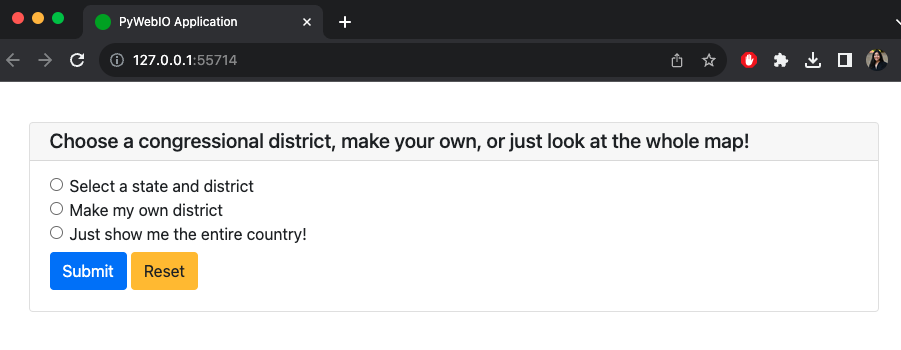

In [11]:
display.Image("options.png")

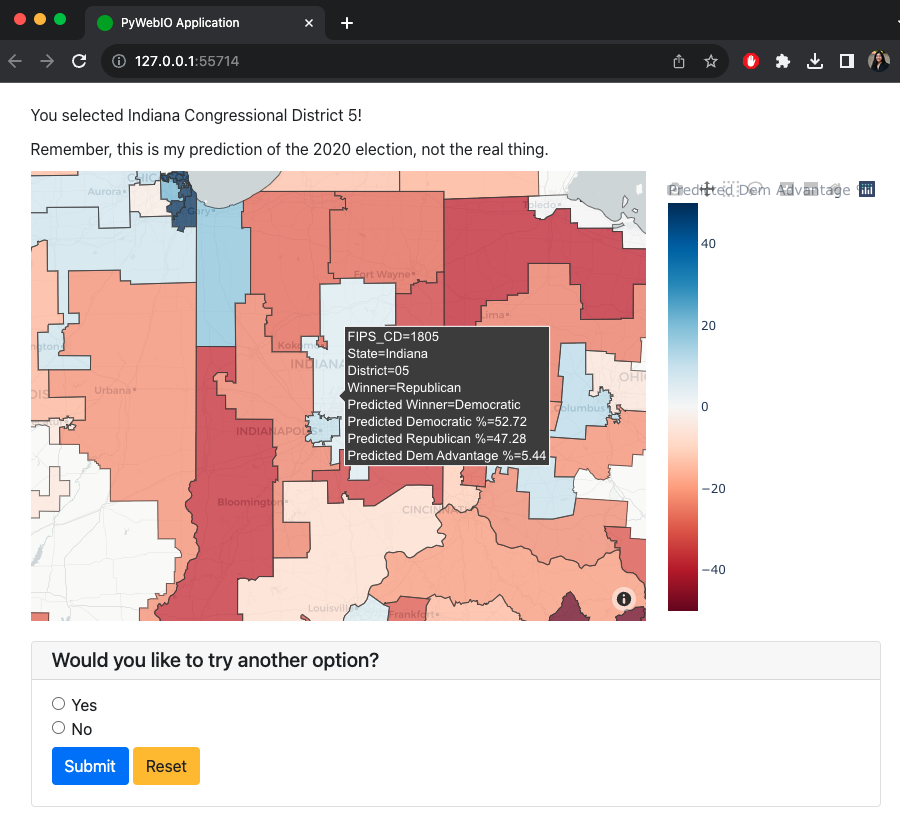

In [12]:
display.Image("select.png")

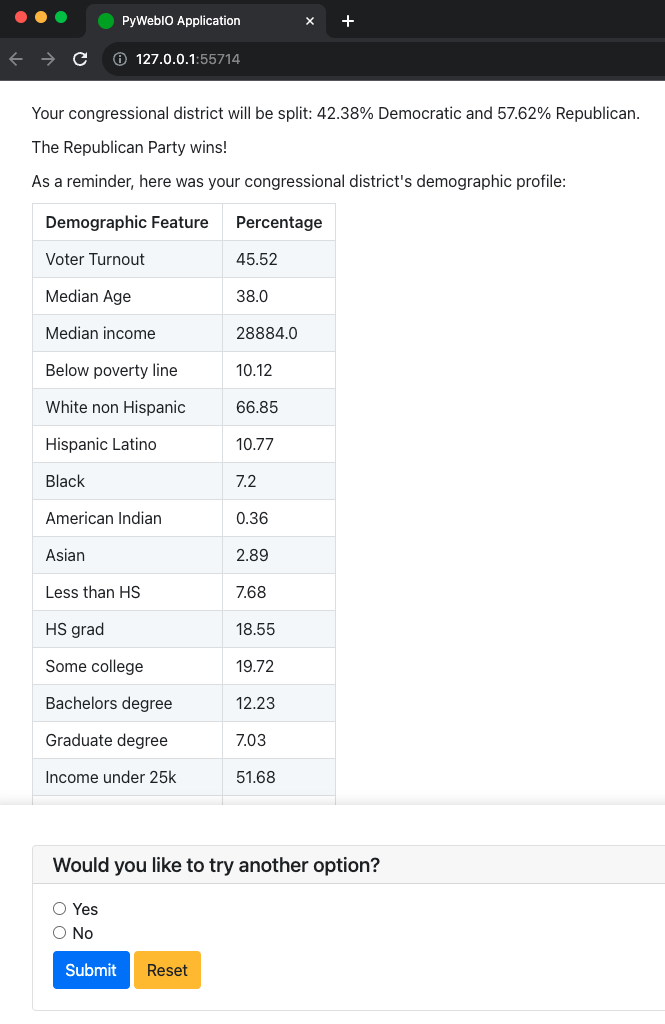

In [13]:
display.Image("user_cd.png")

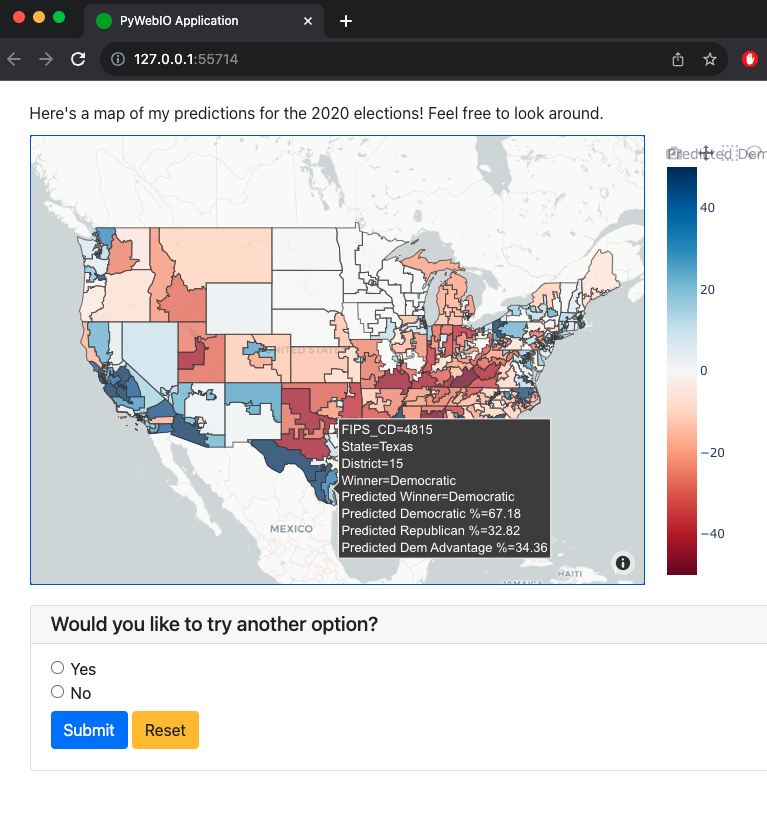

In [14]:
display.Image("whole.png")

## Concluding Remarks
My project on predicting the results of 2020 congressional house elections turned out pretty well! It displays the potential of data science and machine learning in political science and the study of electoral dynamics. Analyzing demographic data and historical voting data allows us to predict election outcomes. While my machine learning model itself was not the greatest, I am proud of the other technical abilities I learned throughout this process, and how it highlights the possibilities of using these methods and techniques in political and social sciences.

In terms of ethical ramifications, I don't think my project is of much danger (the model is not performing well enough for it to be of any use to anyone). However, with a stronger model, presidential campaigns could use something similar to identify which states could be considered swing states and therefore where to focus on while campaigning. It could also tell SuperPACs which states are most vulnerable to their influence, and where they can dump money on independent expenditures to exert undue, unchecked influence in electoral politics. The potential for predictive models to influence elections raises questions about the role of technology in democracy, and is something that needs to be carefully managed.

One side gaining advantages in politics will always be construed by the other side as unfair or undue, regardless of the situation. It is difficult for me to be unbiased about who should or should not deserve a tool like this for political gain. With that being said, I hope you enjoyed my project! If you want to look into something similar and much more well done, check out [this video](https://www.youtube.com/watch?v=Lq-Y7crQo44&ab_channel=AlphaPhoenix) which details the development an insanely powerful redistricting algorithm that, if in the wrong hands, could prove detrimental for American democracy.